# **PART I: INTRODUCTION**

# **Chapter 1: A Teaser Example**

- Simple example: a parabola along the positive x-axis.
- There are 2 solutions, 2 modes, one above and one below the x-axis.
- A conventional learning approach will give us a wrong approximation like the red line in the figure.
- With an improved learning setup, like a discretized numerical solver, we can accurately represent at least 1 of the modes (green).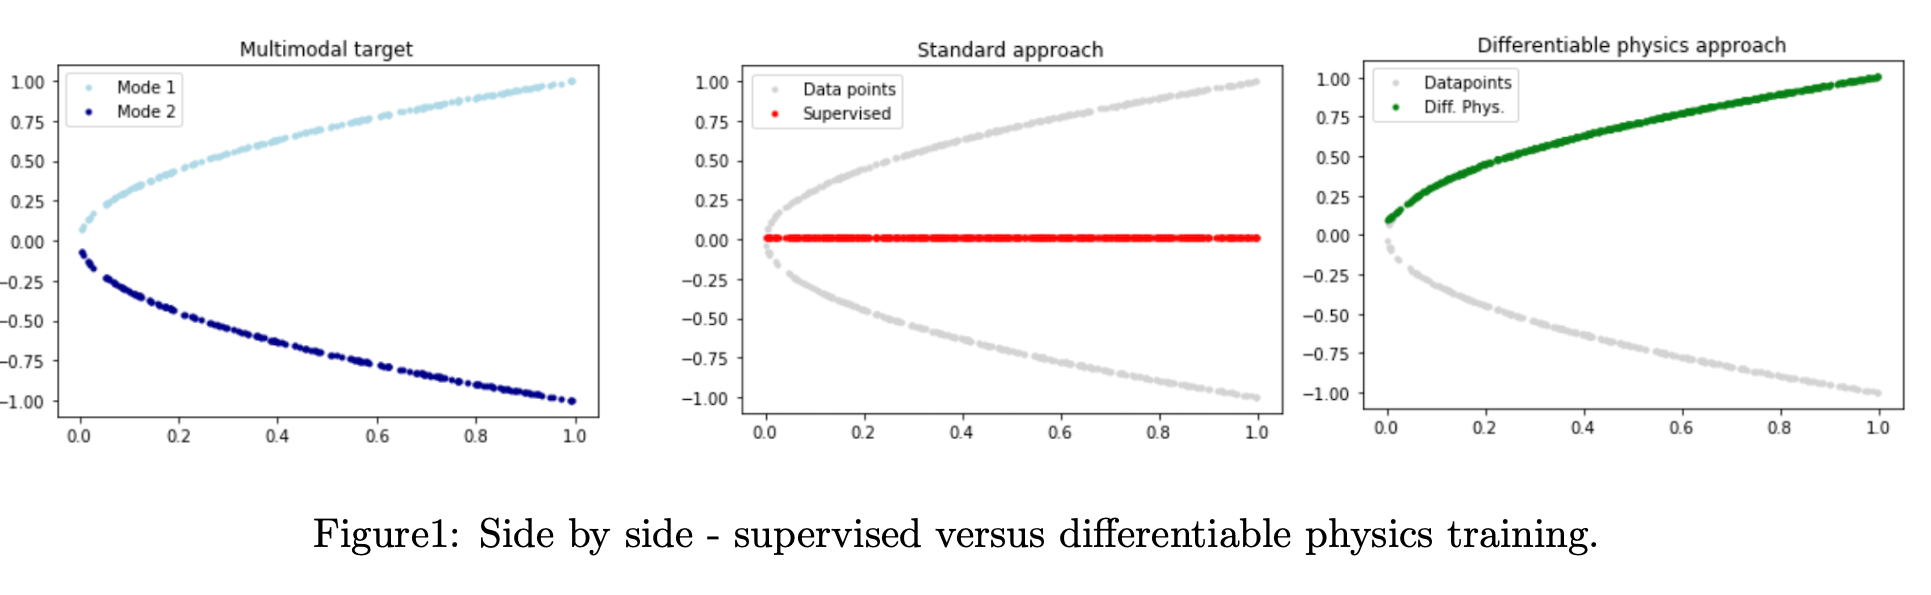

## 1.1 Differentiable physics

- Key concept: *differentiable physics* (DP).
- Use domain knowledge in form of model equations, and then integrate discretized versions of these models into the training process.
- Having differentiable formulations is crucial for this process to support training of NNs.

Properties of DL via DP using an example:
- Wanna find an unknown function $f^{*}$, such that $f^{*}: X → Y$. Idealized version of this function is denoted as $f$.
- Assume also we have a generic diff. eq. $curly P^{*}:Y → Z$ (our model eq.), that encodes a property of the solutions, e.g., some real world behavior that we would like to match.
- The model we'll look at the in the following is a mapping $curlyP^{*}:Y \rightarrow X$.

**Supervised training approach**:
- Use a NN $f$ to learn the unknwon function $f*$.
- Get a dataset by getting $x$ from $X$ and $y$ from $Y$.
- And train the NN on this data.

**Differentiable physics approach**:
- Use a discretized version of the model $P$.
- Employ $P$ to guide the training of $f$.
- $f$ will be aware of our *simulator* $P$ and will *interact* with it.


> In order for the DP approach to work, $P$ has to be differentiable. These differentials (gradients) are what drive the learning process.

## 1.2 Finding the inverse function of a parabola

- Given $P:y→y^2$
- Find unknown function $f$ s.t., $P(f(x)) = x$. Guess: $f(x) = \sqrt{x}$.
- Discretization can be given by representing x and y via float32 ints.

- Let's train a NN to approximate this inverse mapping $f$ in the classical supervised manner.

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [6]:
# creating the X-data
N = 200   # number of samples
X = np.random.random(N)   # random values between 0 and 1

In [15]:
# creating the solution values
sign = (-np.ones((N,)))**np.random.randint(2, size=N) # creates vector of -1 and +1 randomly: 200 dimensional

y = sign * np.sqrt(X)

Define the NN, loss, and other hyperparameters using Keras.
- 3 hidden layers
- 10 inputs and 1 for the final layer

In [18]:
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
nn_solver = keras.Sequential([
    layers.Dense(10, activation="relu", input_shape=(1,)),
    layers.Dense(10, activation="relu"),
    layers.Dense(1, activation="linear")
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Implement the `compile()` and `fit()` methods to train the NN.

In [22]:
# optimizer and loss
nn_solver.compile(
    optimizer="adam",
    loss="mse"
)

# training

results_nn = nn_solver.fit(X, y,
                           epochs=5,
                           batch_size=5,
                           verbose=1)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4981
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4937
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5045 
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4568 
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4914 


Plotting the loss curve:

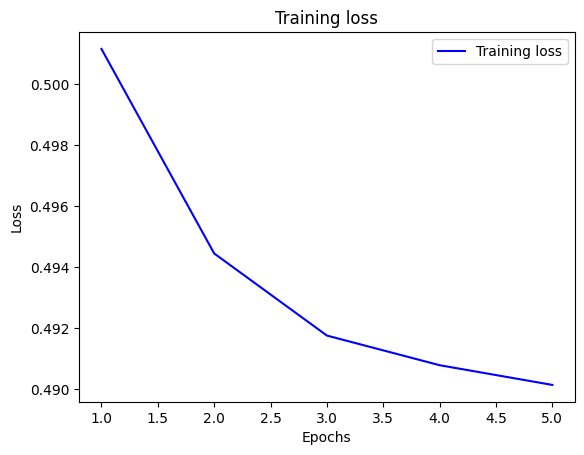

In [25]:
import matplotlib.pyplot as plt
results_dict = results_nn.history
loss_values = results_dict["loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "b", label="Training loss") # bo for blue dot
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Dataset and NN are both small so training converges quickly.
- Predictions are nowhere near the solution we were hoping to find.

Let's plot:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


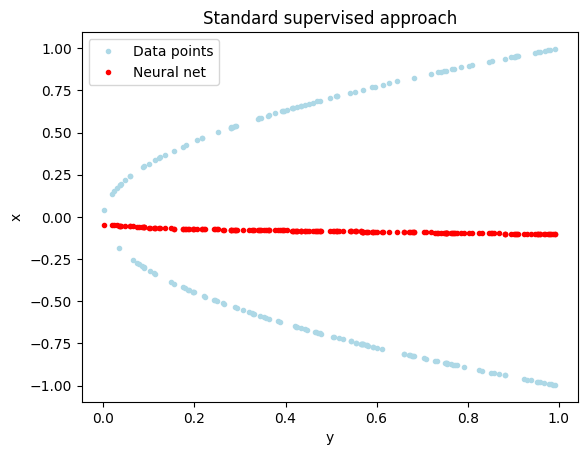

In [26]:
plt.plot(X, y, '.', label="Data points", color="lightblue")
plt.plot(X, nn_solver.predict(X), '.', label="Neural net", color="red")
plt.xlabel('y')
plt.ylabel('x')
plt.title('Standard supervised approach')
plt.legend()
plt.show()

- Totally wrong!
- Notice: red line is also not perfectly at 0 → caused by coarse sampling with only 200 points, we need *dense sampling*.

## 1.3 Differentiable physics approach

- Apply DP approach.
- Directly include discretized model $P$ into the training.
- Keep the same $x$ locations from previous case.
- New instance of NN with same architecture as before.

In [41]:
# re-use the X data
# y is evaluated on the go

# the model
nn_dp = keras.Sequential([
    layers.Dense(10, activation="relu", input_shape=(1,)),
    layers.Dense(10, activation="relu"),
    layers.Dense(1, activation="linear")
])


In [42]:
# loss
mse = keras.losses.MeanSquaredError()
def loss_dp(y_true, y_pred):
  return mse(y_true, y_pred**2)

nn_dp.compile(
    optimizer="adam",
    loss=loss_dp
)

In [43]:
#training

results_dp = nn_dp.fit(X, X, epochs=5, batch_size=5, verbose=1)

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2467   
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1200
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0029 
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


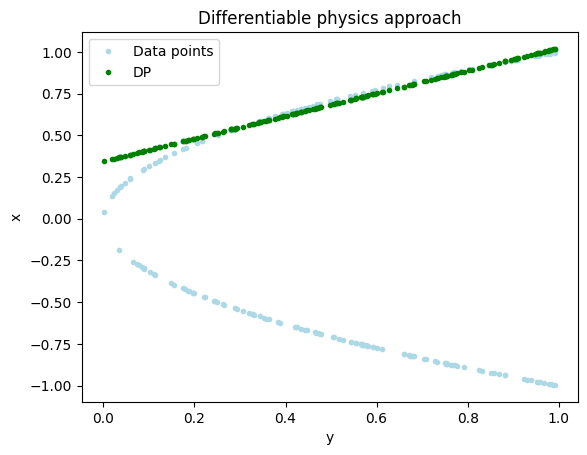

In [44]:
# results
plt.plot(X, y, '.', label="Data points", color="lightblue")
# plt.plot(X, nn_solver.predict(X), '.', label="Neural net", color="red")
plt.plot(X, nn_dp.predict(X), '.', label="DP", color="green")
plt.xlabel('y')
plt.ylabel('x')
plt.title('Differentiable physics approach')
plt.legend()
plt.show()

Looks much better.

BUT, how?

- Prevented undersired averaging of multiple modes in the solution by evaluating discrete model w.r.t. the network's predictions, rather than using a pre-computed solution.
  - This prevents an averaging of the modes that exist in the *solution manifold*.
- We're getting only 1 side of the curve——because we're representing solutions with a deterministic function. Thus, we can only represent a single mode. Whether it's top or bottom is determined by the random initialization of the weights in the NN.
- To compute different modes, gotta extend the NN to capture full distribution of the outputs and parameterize it with additional dimensions.
- Network essentially learns a linear approximation of 1/2 of the parabola.
  - Our NN is weak and shallow.
- Additionally, the even spread of sample points along the x-axis bias the NN towards the larger y-values, these contibute more to the loss, and hence the network invests most of its resources to reduce the error in this region.

## 1.4 Discussion

- Supervised learning can fail in cases with multiple solution modes, as it may average the modes, leading to incorrect results.  
- Practical PDEs (Partial Differential Equations) often involve unknown and varying modes in their solution manifolds.  
- A key example is bifurcations in fluid flow, such as smoke rising above a candle, which can oscillate randomly due to small perturbations.  
- *Numerical perturbations* in symmetric setups can cause flows to deviate in unpredictable directions, making averaged results unphysical.
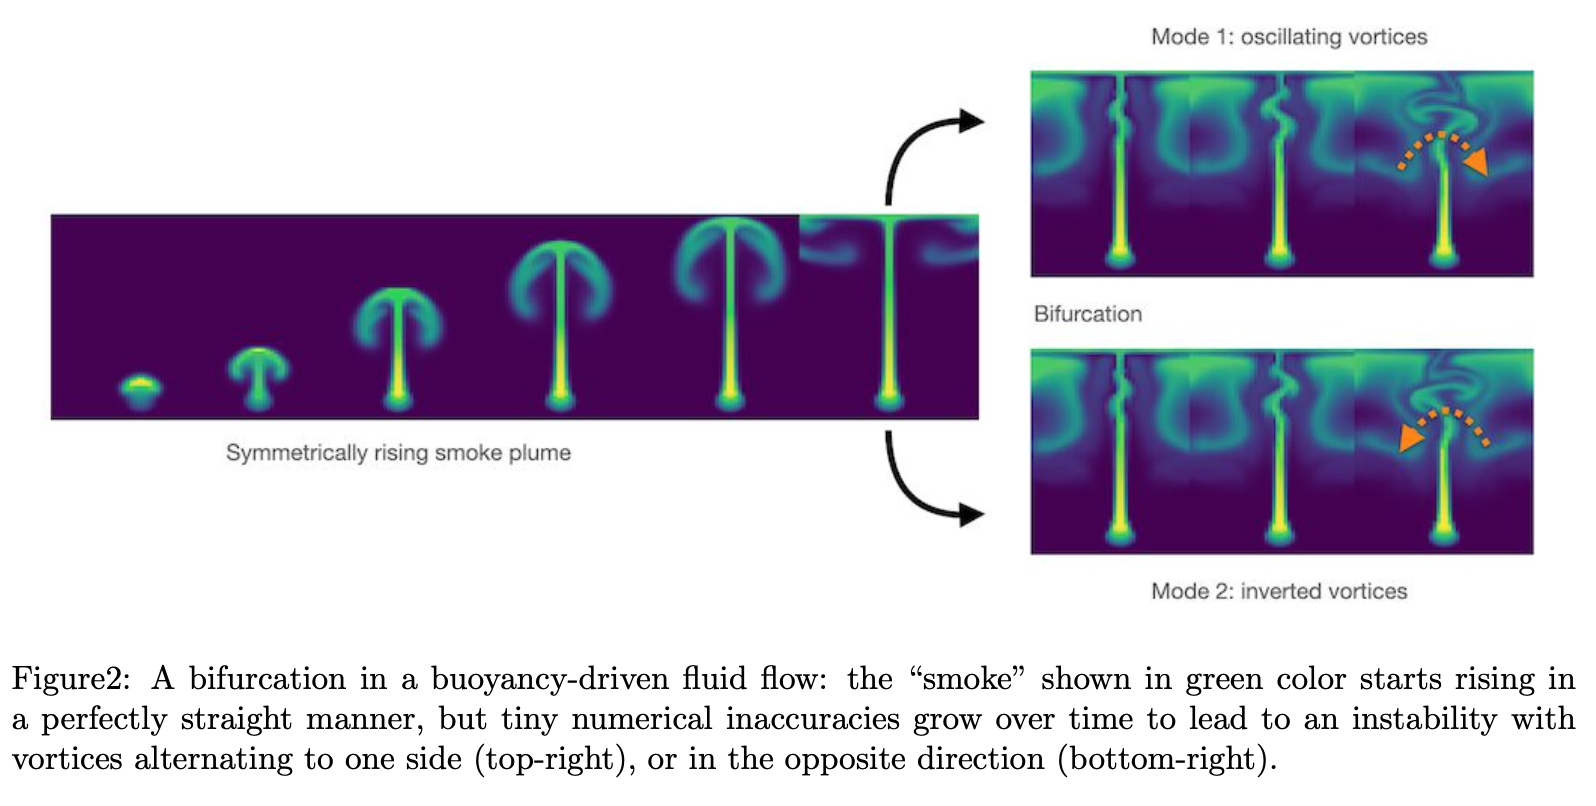  
- Recovering distinct modes is crucial in numerical solutions to avoid oversimplified results.  
- The text emphasizes the use of differentiable physics for training models to handle complex, practical cases instead of relying solely on supervised learning.  

## 1.5 Next steps



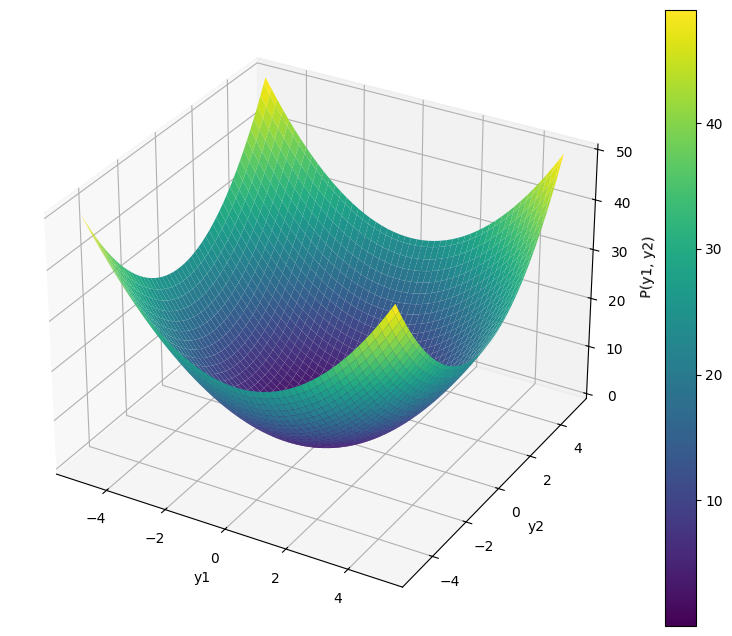

In [45]:
# import numpy as np
# import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create grid points
y1 = np.linspace(-5, 5, 100)
y2 = np.linspace(-5, 5, 100)
Y1, Y2 = np.meshgrid(y1, y2)

# Calculate P
P = Y1**2 + Y2**2

# Create 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Y1, Y2, P, cmap='viridis')

# Labels
ax.set_xlabel('y1')
ax.set_ylabel('y2')
ax.set_zlabel('P(y1, y2)')

plt.colorbar(surf)
plt.show()